In [88]:
import numpy as np
# import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
# import sys
from matplotlib import pyplot as plt

In [89]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')
CHUNK_SIZE_L = 100000
CHUNK_SIZE_S = 50000

In [90]:
def process_dataarray(da_o3):
    if not "DATETIME" in da_o3.coords:
        time_chunks = CHUNK_SIZE_L if da_o3.size > 500000 else CHUNK_SIZE_S
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'time': time_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks= time_chunks)
    
    else:
        time_chunks = CHUNK_SIZE_L if da_o3.size > 500000 else CHUNK_SIZE_S
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks= time_chunks)
    return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [91]:
import OSIRIS.OSIRIS_helper as OSIRIS
import PEARL_FTIR.PEARL_FTIR_helper as PEARL

In [92]:
ALT_MIN, ALT_MAX = 10.5, PEARL.upper_alt_bound
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)

In [93]:
daO = OSIRIS.get_column_DU(ALT_MIN, ALT_MAX)
daP = PEARL.get_column_DU(ALT_MIN, ALT_MAX)

In [94]:
daO = process_dataarray(daO)
daP = process_dataarray(daP)

In [95]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)

In [96]:
o3O_arr = daO.values.astype(np.float32)
latO = daO.latitude.values
lonO = daO.longitude.values
tO = daO.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
first_time_mask = (tO >= tP_min) & (tO <= tP_max) & ~np.isnan(o3O_arr)
tO_filtered = tO[first_time_mask]
o3O_arr_filtered = o3O_arr[first_time_mask]
latO_filtered = latO[first_time_mask]
lonO_filtered = lonO[first_time_mask]

client.close()
cluster.close()
del o3O_arr, latO, lonO
gc.collect() 

44301

In [97]:
tO_ns = tO_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3O_coincidences = []
o3P_coincidences_idx = []
o3O_coincidences_idx = []
days_of_year = []
no_column_O = []
time = []
measurement_times_dt = []
measurement_times = []

time_bins = np.arange(tO_ns.min(), tO_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tO_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing PEARL FTIR point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tO_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latO_filtered[time_valid_indices]
    candidate_lons = lonO_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3O_coincidences.append(o3O_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1

        o3O_coincidences_idx.append(best_L_idx)
        o3P_coincidences_idx.append(s_idx)

        dt = tO_ns[best_L_idx]
        dt = dt.astype('datetime64[ns]')
        day_of_year = ((dt - dt.astype('datetime64[Y]'))   // np.timedelta64(1, 'D')) + 1
        time.append(dt)
        days_of_year.append(day_of_year)
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at PEARL FTIR point {s_idx}...")

        measurement_times.append(tP_ns[s_idx])
        measurement_times_dt.append(tP[s_idx])

o3P_coincidences = np.vstack(o3P_coincidences)
o3O_coincidences = np.vstack(o3O_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing PEARL FTIR point 0/6261...
Found 1000 pairs at PEARL FTIR point 1334...
Found 2000 pairs at PEARL FTIR point 3120...
Found 3000 pairs at PEARL FTIR point 4721...
Total coincidences found: 3459


In [ ]:
# using 10km: before: 3617, before without taking into account nan, 3459

In [99]:
n_coincidences = (~np.isnan(o3O_coincidences)).sum()

In [100]:
n_coincidences

np.int64(3459)

In [101]:
rel, abs, raw = compute_diffs(o3O_coincidences, o3P_coincidences)

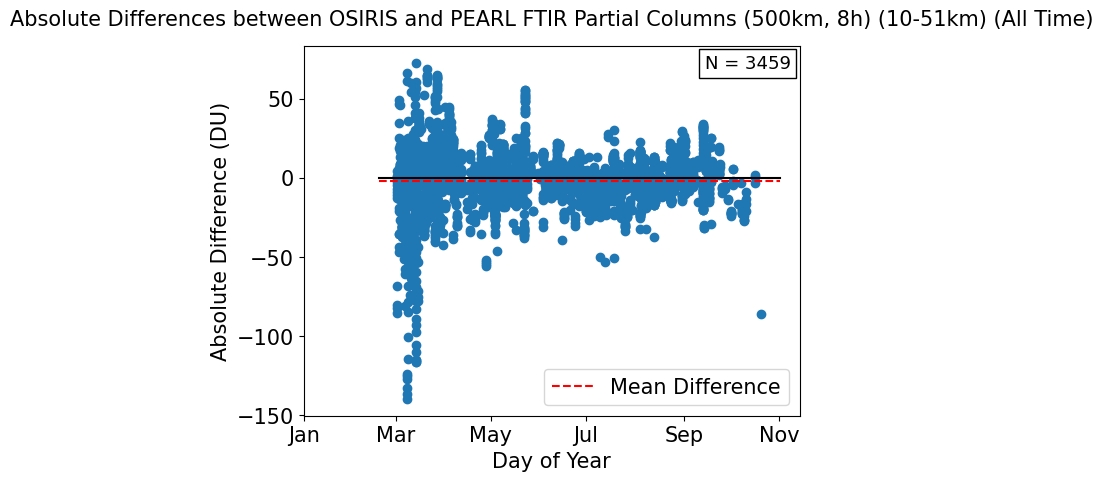

In [102]:
plt.scatter(days_of_year, raw)
raw_mean = np.nanmean(raw)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [raw_mean, raw_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Absolute Difference (DU)")
plt.title("Absolute Differences between OSIRIS and PEARL FTIR Partial Columns" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)
plt.legend()


locs  = np.array([0,  58, 118, 178, 240, 300])
ticks = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]
plt.xticks(locs, ticks)

fig = plt.gcf()
axes = plt.gca()

plt.text(0.808, 0.94, f"N = {n_coincidences}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

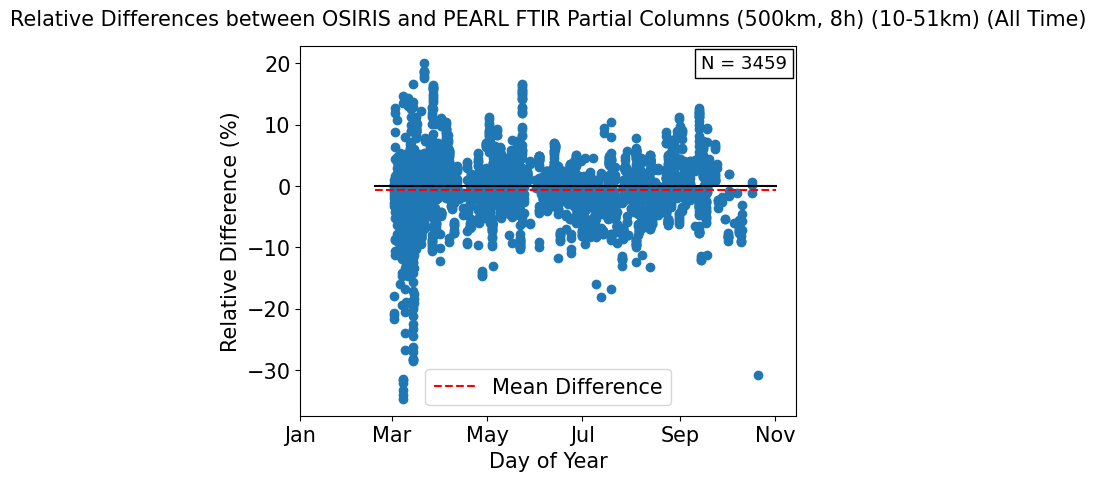

In [103]:
plt.scatter(days_of_year, rel)
rel_mean = np.nanmean(rel)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")
plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Day of Year")
plt.ylabel("Relative Difference (%)")

plt.title("Relative Differences between OSIRIS and PEARL FTIR Partial Columns" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)
locs  = np.array([0,  58, 118, 178, 240, 300])
ticks = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]
plt.xticks(locs, ticks)
plt.legend()
fig = plt.gcf()
axes = plt.gca()

plt.text(0.808, 0.94, f"N = {n_coincidences}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [104]:
o3O_std = np.nanstd(o3O_coincidences)
o3P_std = np.nanstd(o3P_coincidences)
o3O_mean = np.nanmean(o3O_coincidences)
o3P_mean = np.nanmean(o3P_coincidences)

L_minus_mean = (o3O_coincidences - o3O_mean)
S_minus_mean = (o3P_coincidences - o3P_mean)

summing = np.nansum((L_minus_mean / o3O_std) * (S_minus_mean / o3P_std)) / (len(L_minus_mean) - 1)

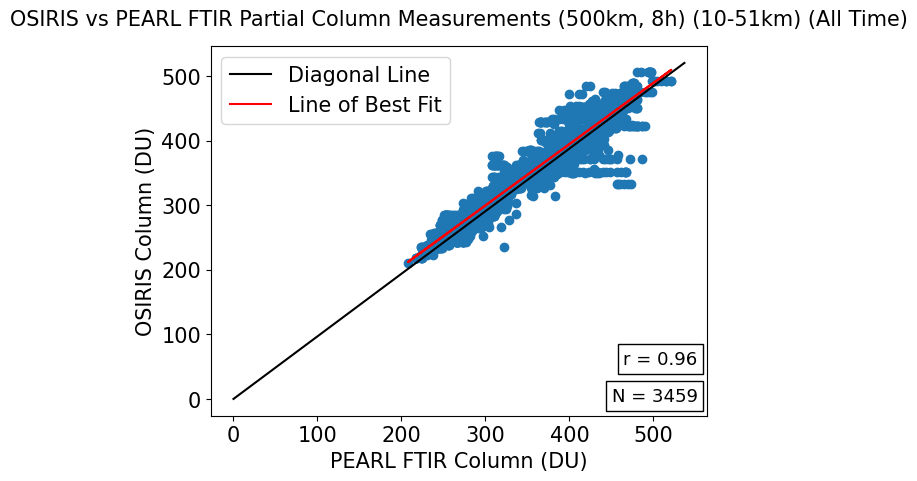

In [105]:
plt.scatter(o3P_coincidences, o3O_coincidences, color = "C0")
plt.xlabel("PEARL FTIR Column (DU)")
plt.ylabel("OSIRIS Column (DU)")

plt.title("OSIRIS vs PEARL FTIR Partial Column Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)

xlims = plt.xlim()
ylims = plt.ylim()
plt.plot([0, xlims[1]], [0, ylims[1]], color = "black", label = "Diagonal Line")

mask = np.isfinite(o3O_coincidences) & np.isfinite(o3P_coincidences)
o3L_coincidences_nonan = o3O_coincidences[mask]
o3S_coincidences_nonan = o3P_coincidences[mask]

slope, intercept = np.polyfit(o3S_coincidences_nonan, o3L_coincidences_nonan, 1)
line = slope * o3P_coincidences + intercept
plt.plot(o3P_coincidences, line, color = "red", label = "Line of Best Fit")

# plt.xlim(200,600)
plt.legend()

fig = plt.gcf()
axes = plt.gca()

plt.text(0.808, 0.04, f"N = {n_coincidences}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.8315, 0.14, f"r = {summing:.2f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_34800\3281125027.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))


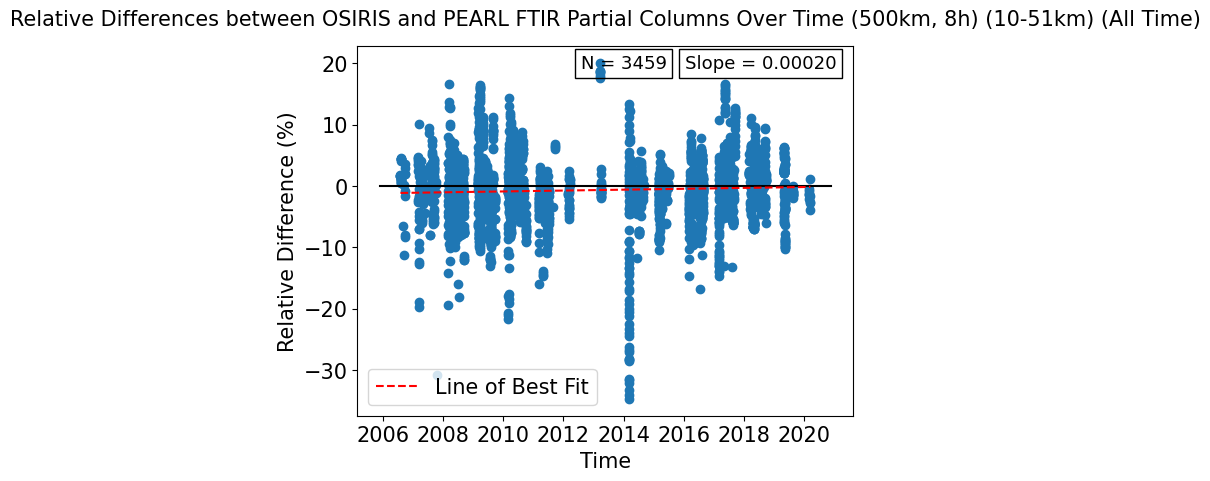

In [106]:
import matplotlib.dates as mdates
import pandas as pd
time_ordinal = mdates.date2num(pd.to_datetime(time))
# time_ordinal = np.array(time).astype('datetime64[ns]').astype(np.int64)
plt.scatter(time_ordinal, rel)
# rel_mean = np.nanmean(rel)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")

rel_is_nan = np.isnan(rel[:,0])
nonan_rel = rel[~rel_is_nan]
nonan_time_ordinal = time_ordinal[~rel_is_nan]
nonan_time = np.array(time)[~rel_is_nan]

slope, intercept = np.polyfit(nonan_time_ordinal, nonan_rel, 1)
line = slope * nonan_time_ordinal + intercept
plt.plot(nonan_time, line, color = "red", label = "Line of Best Fit", linestyle = "dashed")

# plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Time")
plt.ylabel("Relative Difference (%)")
plt.title("Relative Differences between OSIRIS and PEARL FTIR Partial Columns Over Time" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend(loc = "lower left")
fig = plt.gcf()
axes = plt.gca()

plt.text(0.450, 0.94, f"N = {n_coincidences}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_34800\2894581984.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))


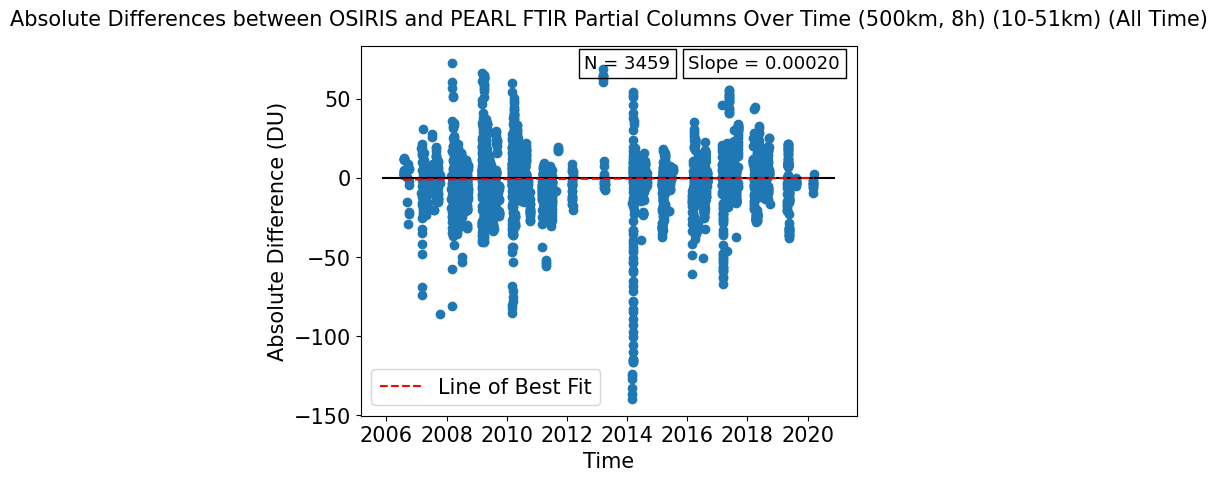

In [107]:
import matplotlib.dates as mdates
import pandas as pd
time_ordinal = mdates.date2num(pd.to_datetime(time))
# time_ordinal = np.array(time).astype('datetime64[ns]').astype(np.int64)
plt.scatter(time_ordinal, raw)
# rel_mean = np.nanmean(raw)
xlims = list(plt.xlim())
plt.plot(xlims, [0, 0], color = "black")

raw_is_nan = np.isnan(raw[:,0])
nonan_raw = raw[~raw_is_nan]
nonan_time_ordinal = time_ordinal[~raw_is_nan]
nonan_time = np.array(time)[~raw_is_nan]

slope, intercept = np.polyfit(nonan_time_ordinal, nonan_rel, 1)
line = slope * nonan_time_ordinal + intercept
plt.plot(nonan_time, line, color = "red", label = "Line of Best Fit", linestyle = "dashed")

# plt.plot(xlims, [rel_mean, rel_mean], color = "red", linestyle = "dashed", label = "Mean Difference")
plt.xlabel("Time")
plt.ylabel("Absolute Difference (DU)")
plt.title("Absolute Differences between OSIRIS and PEARL FTIR Partial Columns Over Time" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15}, pad=15)

plt.legend(loc = "lower left")
fig = plt.gcf()
axes = plt.gca()

plt.text(0.450, 0.94, f"N = {n_coincidences}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
plt.text(0.660, 0.94, f"Slope = {float(slope):.5f}", fontsize=13, transform=axes.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [108]:
import seasonal_columns_helper

seasonal_months = {"DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11]}

seasonalhelper = seasonal_columns_helper.SeasonalHelper(measurement_times, o3P_coincidences, o3O_coincidences)

o3P_seasonal_coincidences = seasonalhelper.seasonal_coincidences1()

o3O_seasonal_coincidences = seasonalhelper.seasonal_coincidences2()

o3P_seasonal_coincidences_times = seasonalhelper.seasonal_times()

n_seasonal_coincidences = seasonalhelper.seasonal_coincidences_count()

no_seasonal_coincidences = seasonalhelper.empty_seasons()

In [109]:
rel_seasonal = {season: compute_diffs(o3O_seasonal_coincidences[season], o3P_seasonal_coincidences[season])[0] for season in seasonal_months}

abs_seasonal = {season: compute_diffs(o3O_seasonal_coincidences[season], o3P_seasonal_coincidences[season])[1] for season in seasonal_months}

rel_diffs_seasonal = {season: np.nanmean(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

rel_std_seasonal = {season: np.nanstd(rel_season, axis = 0) for season, rel_season in rel_seasonal.items()}

abs_diffs_seasonal = {season: np.nanmean(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

abs_std_seasonal = {season: np.nanstd(abs_season, axis = 0) for season, abs_season in abs_seasonal.items()}

o3O_std_seasonal = {season: np.nanstd(season_coincidences) for season, season_coincidences in o3O_seasonal_coincidences.items()}
o3P_std_seasonal = {season: np.nanstd(season_coincidences) for season, season_coincidences in o3P_seasonal_coincidences.items()}
o3O_mean_seasonal = {season: np.nanmean(season_coincidences) for season, season_coincidences in o3O_seasonal_coincidences.items()}
o3P_mean_seasonal = {season: np.nanmean(season_coincidences) for season, season_coincidences in o3P_seasonal_coincidences.items()}

L_minus_mean_seasonal = {season: (o3O_seasonal_coincidences[season] - o3O_mean_seasonal[season]) for season in seasonal_months}
S_minus_mean_seasonal = {season: (o3P_seasonal_coincidences[season] - o3P_mean_seasonal[season]) for season in seasonal_months}

summing_seasonal = {
    season: np.nansum(
        (L_minus_mean_seasonal[season] / o3O_std_seasonal[season]) * (S_minus_mean_seasonal[season] / o3P_std_seasonal[season]) 
    ) / (len(L_minus_mean_seasonal[season]) - 1)
    for season in seasonal_months
}

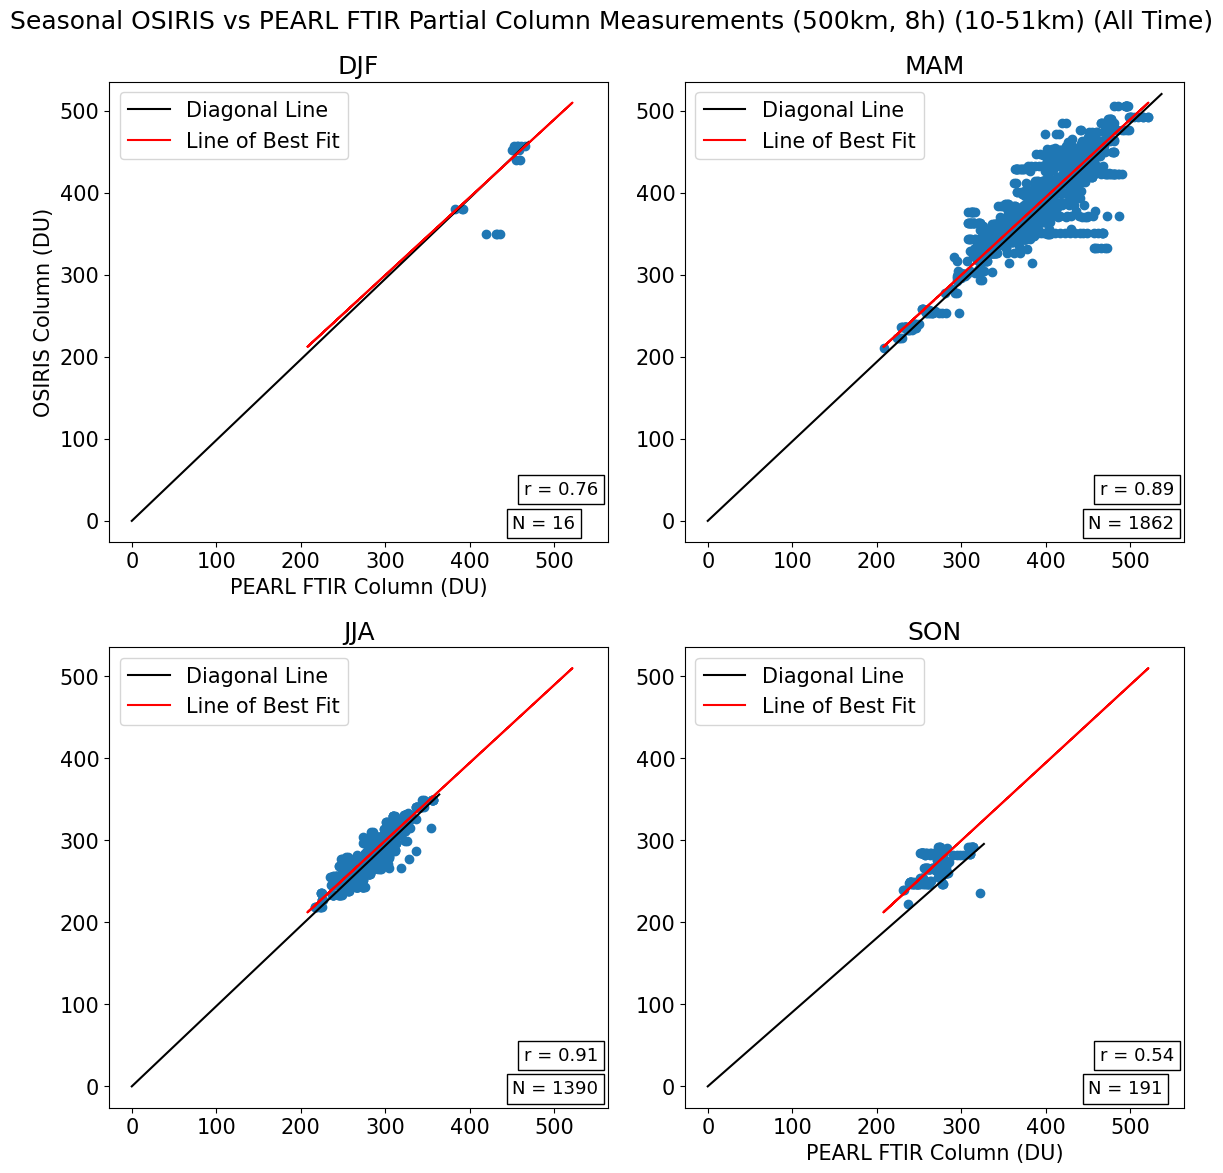

In [110]:
fig, axes = plt.subplots(2,2, figsize = (12,12))

xmins = []
xmaxs = []
ymins = []
ymaxs = []

for i, season in enumerate(seasonal_months):
    ax = axes.flat[i]
    ax.scatter(o3P_seasonal_coincidences[season], o3O_seasonal_coincidences[season])
    ax.set_title(season)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    ax.plot([0, xmax], [0, ymax], color = "black", label = "Diagonal Line")

    slope, intercept = np.polyfit(o3S_coincidences_nonan, o3L_coincidences_nonan, 1)
    line = slope * o3P_coincidences + intercept
    ax.plot(o3P_coincidences, line, color = "red", label = "Line of Best Fit")

    ax.text(0.808, 0.03, f"N = {len(o3O_seasonal_coincidences[season])}", fontsize=13, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
    ax.text(0.831, 0.103, f"r = {summing_seasonal[season]:.2f}", fontsize=13, transform=ax.transAxes, bbox=dict(facecolor=None, edgecolor='black', fill = False))
    ax.legend()
    
    if season in no_seasonal_coincidences:
        ax.set_visible(False)

    top_ax = ax
    top_ymin, top_ymax = top_ax.get_ylim()

    top_xmin, top_xmax = top_ax.get_xlim()

    xmins.append(top_xmin)
    xmaxs.append(top_xmax)

    ymins.append(top_ymin)
    ymaxs.append(top_ymax)

min_xlim, max_xlim = min(xmins), max(xmaxs)
min_ylim, max_ylim = min(ymins), min(ymaxs)

for ax in axes.flat:
    ax.set_xlim(min_xlim, max_xlim)
    ax.set_ylim(min_ylim, max_ylim)


axes[0, 0].set_ylabel("OSIRIS Column (DU)")
axes[0, 0].set_xlabel("PEARL FTIR Column (DU)")
axes[1, 1].set_xlabel("PEARL FTIR Column (DU)")

plt.suptitle("Seasonal OSIRIS vs PEARL FTIR Partial Column Measurements" + f" ({MAX_DIST_KM}" + "km," + " " + f"{TIME_TOL_HOURS}" + "h)" + f" ({int(ALT_MIN - 0.5)}-{int(ALT_MAX + 0.5)}km)" + " (All Time)", fontdict = {'fontsize': 15})

fig.tight_layout()